In [75]:
#Configuracion inicial
%matplotlib inline
import matplotlib.pyplot as plt #librería para graficas de python
import numpy # extiende las librerias de matemática de python
import pandas #libreria para procesamiento de datos muy usada en la industria
import seaborn # Extiende las funcionalidades de matplotlib, muy usado en data visualization
import os # librería para interactuar con el sistema de archivos 

# Con esto hacemos los gráficos más grandes, adecuados para el proyector.
seaborn.set_context(context='talk', font_scale=1.2)

# Archivos
sca_dir = 'DATA/'
archivos_sca = os.listdir(sca_dir)

# Cargamos los datos de los archivos en el array `data`
# se mapea la info de cada caso n a la posicion n-1 en el array
data = []
for caso in range(len(archivos_sca)):
    aux = pandas.read_csv(sca_dir + archivos_sca[caso])
    data.append(aux)

print("archivos cargados: ",', '.join(archivos_sca))

archivos cargados:  parte1-caso1.csv, parte1-caso3.csv, parte1-caso2.csv


## Ocupacion de buffers en el sistema

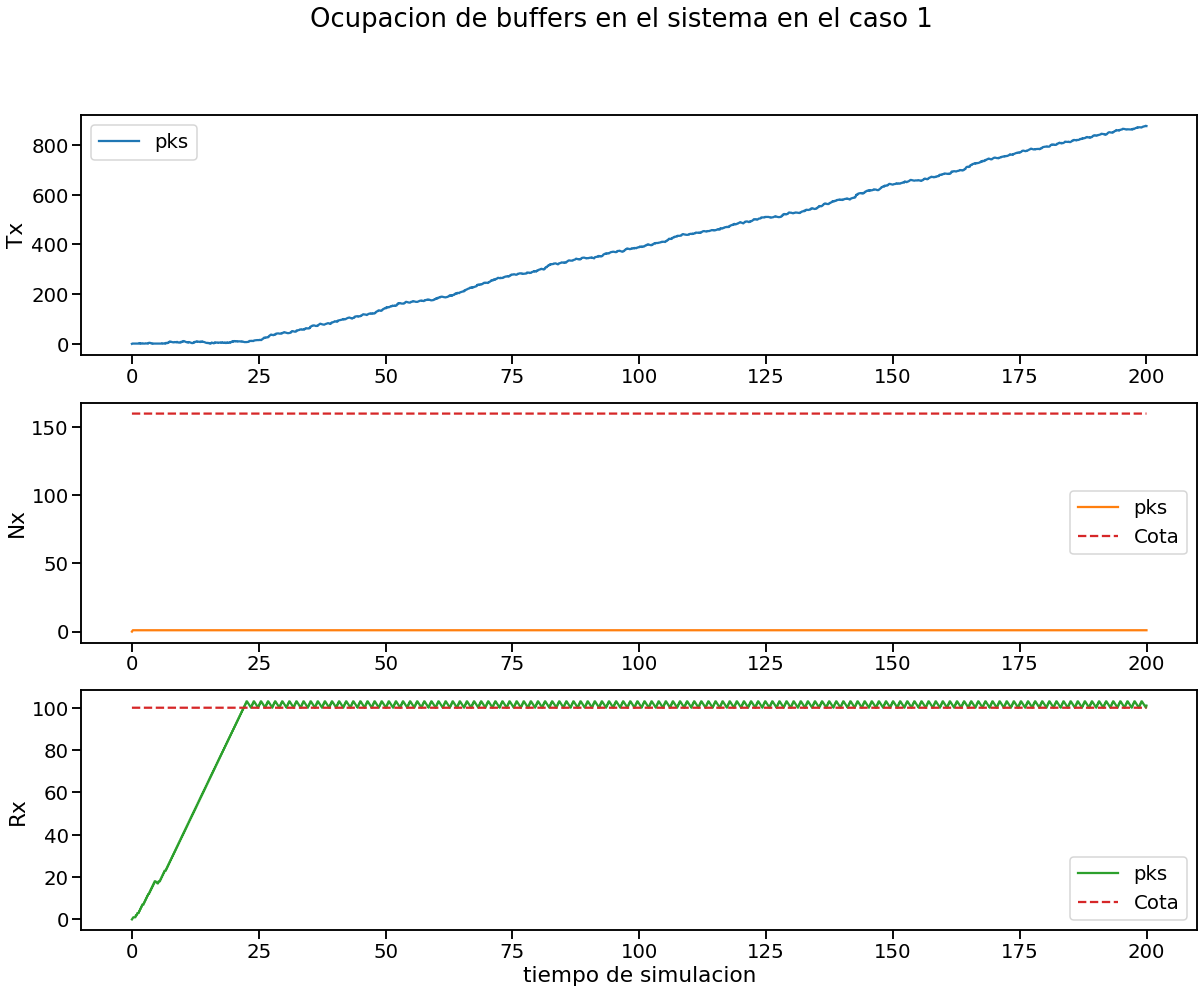

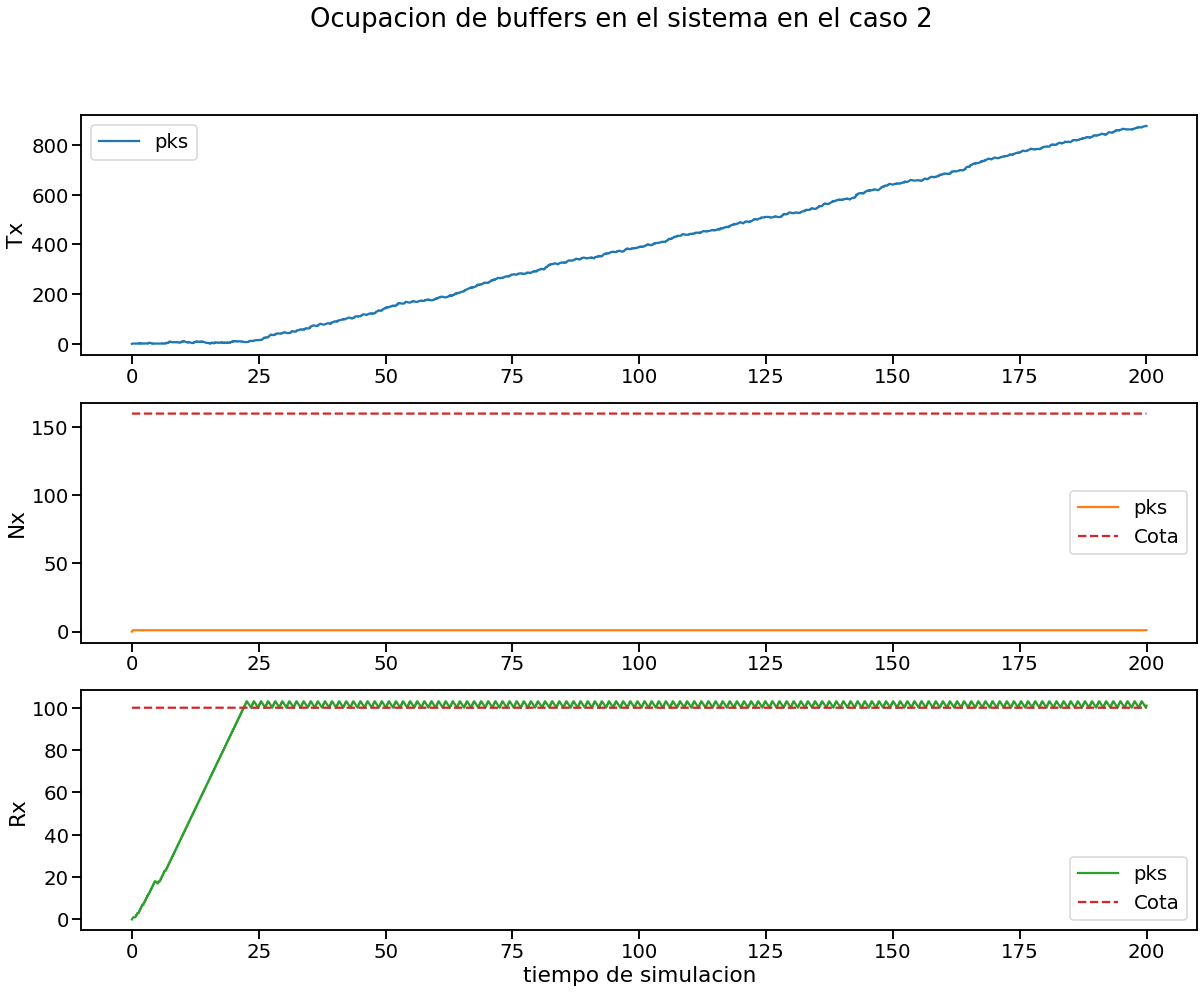

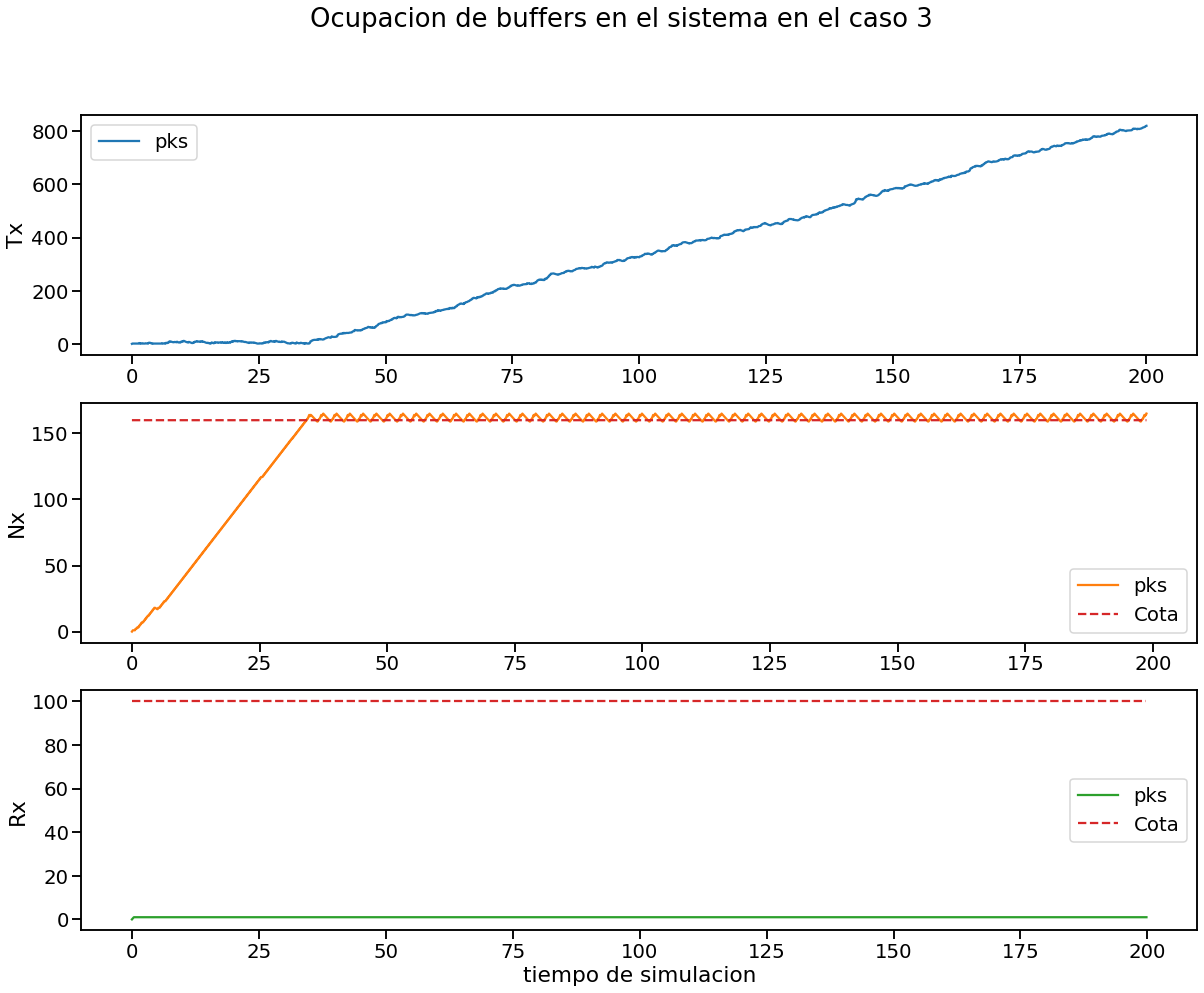

In [76]:
for c in range(len(data)):
    caso = data[c]

    # Extraemos los valores de nuestro "vector"
    time_gen = caso.loc[(caso['module'] == 'Network.nodeTx.traTx') & (caso['name'] == 'BufferSizeVector'), 'vectime'].tolist()
    buffer_gen = caso.loc[(caso['module'] == 'Network.nodeTx.traTx') & (caso['name'] == 'BufferSizeVector'), 'vecvalue'].tolist()

    time_queue = caso.loc[(caso['module'] == 'Network.queue0') & (caso['name'] == 'BufferSizeVector'), 'vectime'].tolist()
    buffer_queue = caso.loc[(caso['module'] == 'Network.queue0') & (caso['name'] == 'BufferSizeVector'), 'vecvalue'].tolist()
    cota_queue = caso.loc[(caso['type'] == 'config') & (caso['attrname'] == 'Network.queue0.bufferCota'), 'attrvalue'].tolist()
    buffSize_queue = caso.loc[(caso['type'] == 'config') & (caso['attrname'] == 'Network.queue0.bufferSize'), 'attrvalue'].tolist()

    time_sink = caso.loc[(caso['module'] == 'Network.nodeRx.traRx') & (caso['name'] == 'BufferSizeVector'), 'vectime'].tolist()
    buffer_sink = caso.loc[(caso['module'] == 'Network.nodeRx.traRx') & (caso['name'] == 'BufferSizeVector'), 'vecvalue'].tolist()
    cota_sink = caso.loc[(caso['type'] == 'config') & (caso['attrname'] == 'Network.nodeRx.traRx.bufferCota'), 'attrvalue'].tolist()
    buffSize_sink = caso.loc[(caso['type'] == 'config') & (caso['attrname'] == 'Network.queue0.bufferSize'), 'attrvalue'].tolist()

    # convertimos los valores (ahora strings separados por comas) a listas para poder graficarlos
    time_gen = list(map(float,time_gen[0].split()))
    time_queue = list(map(float,time_queue[0].split()))
    time_sink = list(map(float,time_sink[0].split()))
    buffer_gen = list(map(float,buffer_gen[0].split()))
    buffer_queue = list(map(float,buffer_queue[0].split()))
    buffer_sink = list(map(float,buffer_sink[0].split()))
    cota_queue = [float(cota_queue[0])*float(buffSize_queue[0])] * (len(time_queue))
    cota_sink = [float(cota_sink[0])*float(buffSize_sink[0])] * (len(time_sink))

    # Graficamos
    fig, ax = plt.subplots(3,figsize=(20, 15))
    fig.suptitle('Ocupacion de buffers en el sistema en el caso {}'.format(c+1))
    plt.xlabel("tiempo de simulacion")
    #
    ax[0].plot(time_gen,buffer_gen, color='tab:blue', label="pks")
    ax[1].plot(time_queue,buffer_queue, color='tab:orange', label="pks")
    ax[1].plot(time_queue,cota_queue, color='tab:red', label="Cota", linestyle='--')
    ax[2].plot(time_sink,buffer_sink, color='tab:green', label="pks")
    ax[2].plot(time_sink,cota_sink, color='tab:red', label="Cota", linestyle='--')
    #
    ax[0].set_ylabel("Tx")
    ax[1].set_ylabel("Nx")
    ax[2].set_ylabel("Rx")
    #
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show

## Paquetes generados y paquetes consumidos

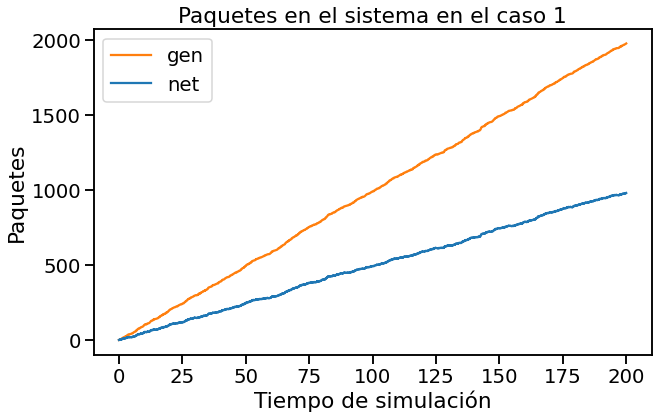

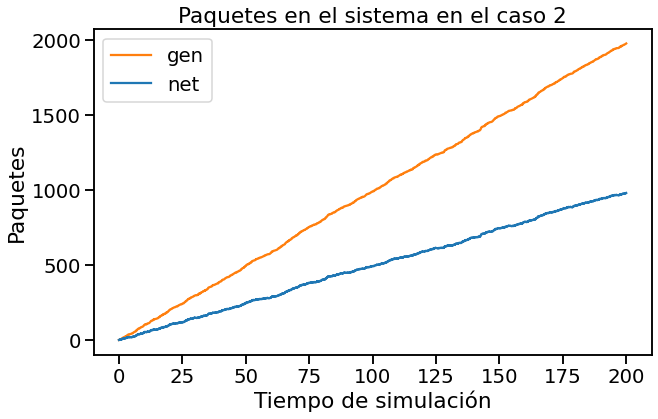

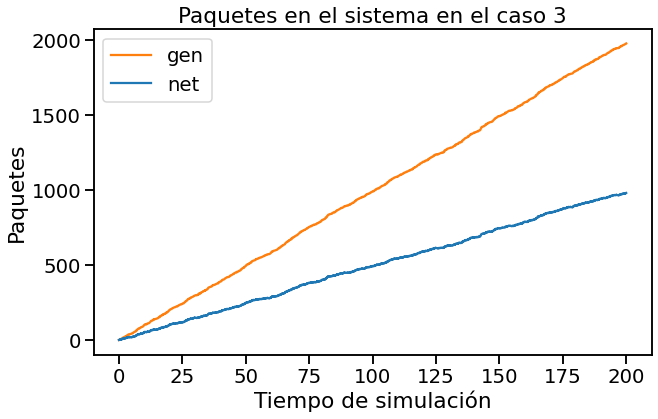

In [77]:
for c in range(len(data)):
    caso = data[c]
    
    # Extraemos la info
    time_gen = caso.loc[(caso['module'] == 'Network.nodeTx.gen') & (caso['name'] == 'packetSent'), 'vectime'].tolist()
    packets_gen = caso.loc[(caso['module'] == 'Network.nodeTx.gen') & (caso['name'] == 'packetSent'), 'vecvalue'].tolist()

    time_sink = caso.loc[(caso['module'] == 'Network.nodeRx.sink') & (caso['name'] == 'packetReceived'), 'vectime'].tolist()
    delay_sink = caso.loc[(caso['module'] == 'Network.nodeRx.sink') & (caso['name'] == 'Delay'), 'vecvalue'].tolist()
    packets_sink = caso.loc[(caso['module'] == 'Network.nodeRx.sink') & (caso['name'] == 'packetReceived'), 'vecvalue'].tolist()

    # Convertimos los valores a flotantes
    time_gen = list(map(float,time_gen[0].split()))
    packets_gen = list(map(float,packets_gen[0].split()))
    time_sink = list(map(float,time_sink[0].split()))
    packets_sink = list(map(float,packets_sink[0].split()))
    delay_sink = list(map(float,delay_sink[0].split()))

    time = []
    count_gen = 0
    count_sink = 0
    while count_gen < len(time_gen) or count_sink < len(time_sink):
        if count_gen < len(time_gen) and ( count_sink >= len(time_sink) or (count_sink < len(time_sink) and time_gen[count_gen] < time_sink[count_sink])):
            time.append(time_gen[count_gen])
            count_gen += 1
        else:
            time.append(time_sink[count_sink])
            count_sink += 1

    generate_packets = []
    count_gen = 0
    for i in range(0,len(time)):
        if count_gen < len(time_gen) and time_gen[count_gen] <= time[i] :
            generate_packets.append(packets_gen[count_gen])
            count_gen += 1
        else:
            generate_packets.append(packets_gen[count_gen-1])

    network_packets = generate_packets.copy()
    count_sink = 0
    sinking_pks = 0
    for i in range(0,len(time)):
        if count_sink < len(time_sink) and time_sink[count_sink] <= time[i]: 
            network_packets[i] -= packets_sink[count_sink]
            sinking_pks = packets_sink[count_sink]
            count_sink += 1
        else:
            network_packets[i] -= sinking_pks
            
    # Graficamos el gráfico de líneas
    plt.figure(figsize=(10, 6))
    plt.plot(time, generate_packets, color='tab:orange', label='gen')
    plt.plot(time, network_packets, color='tab:blue', label='net')
    plt.title('Paquetes en el sistema en el caso {}'.format(c+1))
    plt.xlabel('Tiempo de simulación')
    plt.ylabel('Paquetes')
    plt.legend()
    plt.show()


## Carga util vs carga recibida/ofrecida
Los datos se sacan de todos los casos

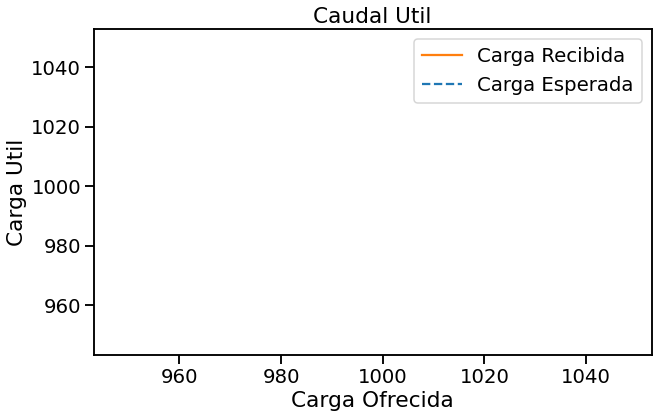

In [78]:

# Calculamos la posicion del ultimo numero de paquetes generados que pudieron ser consumidos en el sink
lastSink_time = time_sink[len(time_sink)-1] 
lastSink_packetGenTime = lastSink_time - delay_sink[len(delay_sink)-1]
pos = 0
while time_gen[pos] != lastSink_packetGenTime :
    pos += 1
# packets_gen[pos] := numero de paquetes generados que pudieron ser consumidos en el sink (o perdidos)

# Carga Util de los casos 1,...,n = cUtil
# Carga ofrecida de los casos 1,...,n = cOfrecida
cUtil = []     # X
for i in range(0, len(data)):
    cUtil.append(packets_gen[pos])

cOfrecida = [] # Y
for i in range(0, len(data)):
    cOfrecida.append(packets_sink[len(packets_sink)-1])

# Graficamos el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(cUtil, cOfrecida, color='tab:orange', label='Carga Recibida')
plt.plot(cUtil, cUtil, color='tab:blue', label='Carga Esperada', linestyle='--')
plt.title('Caudal Util')
plt.xlabel('Carga Ofrecida')
plt.ylabel('Carga Util')
plt.legend()
plt.show()

# FIXME: no esta en paquetes por segundo, no se bien como seria graficar el esperado.